In [377]:
import json
import random

import re
import string
import os.path
import timeit
import itertools
from itertools import chain

import numpy as np
import pandas as pd
import _pickle as pickle

import matplotlib.pyplot as plt
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Dense, Embedding, Flatten, LSTM, Bidirectional, TimeDistributed, Dropout, Activation
from keras.layers import LeakyReLU, concatenate

from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical


%matplotlib inline
%config InlineBackend.figure_formats = ['svg']


In [422]:
plt.style.use('ggplot')

def plot_history(history):
    try:
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
    
    # passed pandas dataframe instead of keras.callbacks.History object
    except AttributeError as e:
        acc = history['acc']
        val_acc = history['val_acc']
        loss = history['loss']
        val_loss = history['val_loss']
        
        
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, label='Training acc')
    plt.plot(x, val_acc, label='Validation acc')
    plt.title('Training vs Validation accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, label='Training loss')
    plt.plot(x, val_loss, label='Validation loss')
    plt.title('Training vs Validation loss')
    plt.legend()
    
    
def display_cm(cm):
    plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.xticks(np.arange(len(l)), l, rotation=45)
    plt.yticks(np.arange(len(l)), l)
    #plt.ylabel('True label')
    #plt.xlabel('Predicted label')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.show()

In [180]:
data_df = pd.read_pickle("data_df_final.pkl")
print(data_df.shape)
data_df.head()

(5629, 13)


,old_index,id,headline,article,category,url,author,timestamp,source_url,source_url_base,source_article,source_article_dict,source_article_len
0,1,1547908619413,"Oracle paid women $13,000 less per year than m...",A class action lawsuit filed against US busine...,technology,https://inshorts.com/prev/en/news/oracle-paid-...,Kanishka Pandey,2019-01-19 14:36:59.000Z,https://www.theguardian.com/technology/2019/ja...,www.theguardian.com,Oracle systematically underpaid thousands of w...,"((sub_headline, Class action alleges female wo...",883
1,3,1544069616805,"Huawei CFO, daughter of Huawei Founder, arrest...","Meng Wanzhou, the Chief Financial Officer of H...",technology,https://inshorts.com/prev/en/news/huawei-cfo-d...,Gaurav Shroff,2018-12-06 04:13:36.000Z,https://techcrunch.com/2018/12/05/huawei-cfo-a...,techcrunch.com,"Huawei CFO arrested in Canada, awaits US extra...","((article, Meng Wanzhou, the chief financial o...",258
2,4,1537606399120,Google asks staff to delete China search engin...,Google has reportedly sent an email to employe...,technology,https://inshorts.com/prev/en/news/google-asks-...,Gaurav Shroff,2018-09-22 08:53:19.000Z,https://www.hindustantimes.com/world-news/goog...,www.hindustantimes.com,Google asks employees to delete China search e...,"((headline, Google asks employees to delete Ch...",369
3,7,1543913478582,PUBG wins 'Best Game of 2018' among 3 Google P...,Online multiplayer battlefield game PlayerUnkn...,technology,https://inshorts.com/prev/en/news/pubg-wins-be...,Kanishka Pandey,2018-12-04 08:51:18.000Z,https://www.hindustantimes.com/tech/pubg-mobil...,www.hindustantimes.com,PUBG Mobile bags Google Play’s best game award...,"((story_highlight, PUBG Mobile bags Google Pla...",398
4,13,1526108551991,Facebook responds to Indian govt's notice on d...,Facebook has responded to the Indian governmen...,technology,https://inshorts.com/prev/en/news/facebook-res...,Aditi Verma,2018-05-12 07:02:31.000Z,https://www.livemint.com/Politics/9wDQpzrUO4Cp...,www.livemint.com,NA,(),1


In [183]:
data_df = data_df[data_df['source_article']!='NA'].sample(frac=1)
data_df[['source_article', 'category' , 'source_url_base', 'source_article_len']].head(10)

,source_article,category,source_url_base,source_article_len
3606,"Govt considers merging Power Finance, REC: Rep...",business,www.livemint.com,482
3484,Adani bags operating rights for Guwahati airpo...,business,www.livemint.com,212
2265,Astronomers identify some of the oldest galaxi...,science,phys.org,761
5196,‘Felt like chopping off his hand’: Misa Bharti...,politics,www.hindustantimes.com,260
3486,"Centre reduces fuel prices by Rs 2.5, tells st...",business,www.hindustantimes.com,478
3133,6 Karni Sena members who gathered outside Kang...,entertainment,www.hindustantimes.com,250
1512,Sarfaraz Ahmed lashes out at Shoaib Akhtar aft...,sports,www.crictracker.com,330
4135,"Rosneft slams Indian taxation system, calls it...",business,www.livemint.com,494
668,Daimler can now test self-driving cars on publ...,technology,techcrunch.com,309
2566,Koffee With Karan 6: Kartik Aaryan reveals he ...,entertainment,www.hindustantimes.com,731


In [186]:
# get a sample
def print_sample(pos):
    sample = data_df.iloc[pos][['source_article', 'category', 'source_article_len']]
    print(sample.source_article)
    print('\n-->Category:', sample.category)
        
print_sample(8)

Daimler can now test self-driving cars on public roads in Beijing
Daimler  has been granted a license to test self-driving vehicles on public roads in Beijing, making it the first international automaker to receive such permission.

The owner of the Mercedes-Benz brand was given the test permit by the Chinese government after extensive closed-course testing, the company said in a statement, adding that it marks a milestone in its research and development efforts in China.

Daimler, which also has licenses in Germany and the U.S., said it will now begin road tests in Beijing.

There are other companies testing autonomous vehicles in China, notably Baidu, which has been on public roads since at least 2016. For Daimler to qualify, the company said it had to add to its Mercedes-Benz test vehicles technical applications from Baidu’s  Apollo platform. Daimler had to undergo testing at the National Pilot Zone (Beijing and Hebei) for Intelligent Mobility, with test drivers receiving rigorous a

In [152]:
data_df['category'].value_counts(1)

sports           0.181872
entertainment    0.170713
politics         0.169930
science          0.156617
technology       0.134103
business         0.130384
automobile       0.056382
Name: category, dtype: float64

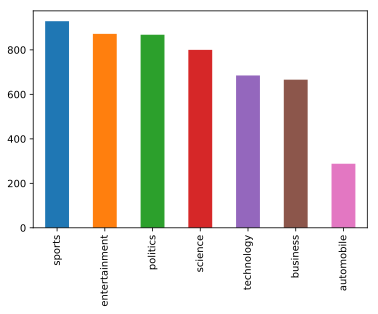

In [156]:
data_df['category'].value_counts().plot(kind = 'bar')

In [81]:
# source article avg length per category
data_df.groupby('category')['source_article_len'].mean()

category
automobile       486.951389
business         451.612613
entertainment    438.431193
politics         465.475806
science          599.511250
sports           451.460710
technology       497.258394
Name: source_article_len, dtype: float64

In [82]:
# 95 percentile article length
data_df['source_article_len'].quantile(.95)

937.2999999999993

In [191]:
# removing stop words and punctiuation
# converting to set to improve search
STOPWORDS = set(stopwords.words('english')) 

def clean_text(text):
    
    #split based on everything except a-z0-9_'.-
    tokens = re.findall("[a-z0-9_'.\-]+", text.lower())
    tokens = [w for w in tokens if not w in STOPWORDS and len(w) > 2 and len(w)<20]
    text = " ".join(tokens)
    
    return text

text = "Daimler, which also has licenses in Germany and the U.S., said it will now begin road tests in Beijing. \
        There are other companies testing autonomous vehicles in China, notably Baidu, which has been on public \
        roads since at least 2016. For Daimler to qualify, the company said"

clean_text(text)


'daimler also licenses germany u.s. said begin road tests beijing. companies testing autonomous vehicles china notably baidu public roads since least 2016. daimler qualify company said'

In [194]:
data_df['source_article'] = data_df['source_article'].apply(lambda x: clean_text(x))
data_df['source_article_len'] = data_df['source_article'].apply(lambda x: len(x.split()))

# 95 percentile article length Decreased
data_df['source_article_len'].quantile(.95)

530.6499999999996

In [199]:
data = data_df[['source_article', 'category', 'source_article_len']]
data.head()

,source_article,category,source_article_len
3606,govt considers merging power finance rec repor...,business,310
3484,adani bags operating rights guwahati airport w...,business,139
2265,astronomers identify oldest galaxies universe ...,science,433
5196,felt like chopping hand misa bharti ram kripal...,politics,169
3486,centre reduces fuel prices 2.5 tells states tu...,business,286


In [197]:
data['category'].unique()

array(['business', 'science', 'politics', 'entertainment', 'sports',
       'technology', 'automobile'], dtype=object)

In [208]:
%%time

x_train, x_test, y_train, y_test = train_test_split(data['source_article'], data['category'], test_size = 0.2, random_state = 11)

# naive bayes classifier
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(x_train, y_train)


y_pred = nb.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names= classes))


accuracy 0.87279843444227
               precision    recall  f1-score   support

     business       0.88      0.11      0.20        62
      science       0.78      0.77      0.78       133
     politics       0.94      0.95      0.95       181
entertainment       0.92      0.99      0.95       181
       sports       0.90      0.98      0.94       166
   technology       0.94      0.96      0.95       167
   automobile       0.70      0.83      0.76       132

  avg / total       0.88      0.87      0.86      1022

Wall time: 2.23 s


In [287]:
# getting tokens

# all tokens
tokens_all = list(chain.from_iterable([article.split() for article in data['source_article']]))

# unique tokens
tokens = list(set(tokens_all))

# will be used for padding
tokens.append("ENDPAD")

VOCAB_SIZE = len(tokens)

# classes
classes = data['category'].unique().tolist()
NUM_CLASSES = len(classes)

print("Total number of tokens:", len(tokens_all))
print("Number of unique tokens:", VOCAB_SIZE)
print("Number of classes:", NUM_CLASSES)


Total number of tokens: 1419708
Number of unique tokens: 82348
Number of classes: 7


In [288]:
# converting tokens, class to indices

MAX_SENT_LEN = 600

word2idx = {w: i for i, w in enumerate(tokens)}
class2idx = {t: i for i, t in enumerate(classes)}

# getting x, y as indexes
x = [[word2idx[w] for w in article.split()] for article in data['source_article']]
y = [class2idx[c] for c in data['category']]

# padding x
x_padded = pad_sequences(x, maxlen = MAX_SENT_LEN, padding = "post", value = word2idx['ENDPAD'], truncating = "post")

# one hot encoding for y
y_ohe = to_categorical(y, num_classes= NUM_CLASSES)


In [289]:
data.head(6)

,source_article,category,source_article_len
3606,govt considers merging power finance rec repor...,business,310
3484,adani bags operating rights guwahati airport w...,business,139
2265,astronomers identify oldest galaxies universe ...,science,433
5196,felt like chopping hand misa bharti ram kripal...,politics,169
3486,centre reduces fuel prices 2.5 tells states tu...,business,286
3133,karni sena members gathered outside kangana ra...,entertainment,155


In [290]:
print(sorted([(class2idx[c], c) for c in classes]))
print(y[:10])
print(y_ohe[:10])

[(0, 'business'), (1, 'science'), (2, 'politics'), (3, 'entertainment'), (4, 'sports'), (5, 'technology'), (6, 'automobile')]
[0, 0, 1, 2, 0, 3, 4, 0, 5, 3]
[[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]


In [405]:
print("ENDPAD index:", word2idx['ENDPAD'], "vocab length:", VOCAB_SIZE)
print("Class:", sorted([(class2idx[c], c) for c in classes]))

print("\n W/o padding")
print(y[2], y_ohe[2], len(x[2]), "\n", x[2])

print("\n With padding")
print(y[2],  y_ohe[2], len(x_padded[2]), "\n", x_padded[2])


ENDPAD index: 82347 vocab length: 82348
Class: [(0, 'business'), (1, 'science'), (2, 'politics'), (3, 'entertainment'), (4, 'sports'), (5, 'technology'), (6, 'automobile')]

 W/o padding
1 [0. 1. 0. 0. 0. 0. 0.] 433 
 [26084, 42416, 34623, 43518, 23462, 80911, 57479, 8457, 43518, 13623, 42239, 18447, 3945, 2085, 31166, 53760, 18624, 76425, 926, 55600, 8149, 18624, 73336, 55600, 26084, 29847, 4834, 43518, 56047, 24118, 51764, 32249, 37274, 80127, 80077, 81886, 50318, 37716, 74395, 38280, 39576, 8457, 43518, 13623, 32157, 5517, 18447, 8496, 77699, 43518, 34032, 56047, 79427, 26833, 9239, 81341, 41472, 66471, 79472, 7771, 41472, 43576, 4834, 43518, 13623, 32157, 5517, 45551, 41472, 3105, 77699, 46444, 37195, 59686, 9239, 76706, 75033, 43376, 43518, 42636, 78904, 73062, 26161, 61922, 29004, 28527, 77699, 43518, 24407, 34032, 73822, 26410, 12955, 60290, 23462, 56633, 44191, 12955, 6934, 77699, 69355, 51742, 27299, 69355, 58753, 24603, 11867, 48040, 69355, 11834, 59855, 16988, 72774, 27952, 

In [292]:
print(len(x), len(y), x_padded.shape, y_ohe.shape)

5108 5108 (5108, 600) (5108, 7)


In [293]:
x_train, x_test, y_train, y_test = train_test_split(x_padded, y_ohe, test_size = 0.2, shuffle = False)

print(y[9])
print(y_train[9])

3
[0. 0. 0. 1. 0. 0. 0.]


In [294]:
print("x_train:", type(x_train), x_train.shape)
print("y_train:", type(y_train), y_train.shape)

print("\nx_test:", type(x_test), x_test.shape)
print("y_test_ohe:", type(y_test), y_test.shape)


x_train: <class 'numpy.ndarray'> (4086, 600)
y_train: <class 'numpy.ndarray'> (4086, 7)

x_test: <class 'numpy.ndarray'> (1022, 600)
y_test_ohe: <class 'numpy.ndarray'> (1022, 7)


In [349]:
# verifying train-test distribution
df_train = data[:4086]
df_test = data[4086:]

df_train['category_idx'] = df_train['category'].apply(lambda x: class2idx[x])
df_test['category_idx'] = df_test['category'].apply(lambda x: class2idx[x])

print((df_train['category_idx'].values == y_train.argmax(axis=1)).all())
print((df_test['category_idx'].values == y_test.argmax(axis=1)).all())
print("\n")

print(df_train['category'].value_counts(1), "\n") 
print(df_test['category'].value_counts(1))

True
True


sports           0.181596
politics         0.173764
entertainment    0.171072
science          0.157122
technology       0.131180
business         0.129956
automobile       0.055311
Name: category, dtype: float64 

sports           0.182975
entertainment    0.169276
politics         0.154599
science          0.154599
technology       0.145793
business         0.132094
automobile       0.060665
Name: category, dtype: float64


C:\Anaconda5.2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Anaconda5.2\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
# creating model 
input = Input(shape=(MAX_SENT_LEN,))

model = Embedding(input_dim = VOCAB_SIZE, output_dim = 25, input_length = MAX_SENT_LEN)(input)
model = Dropout(0.2)(model)

model = Bidirectional(LSTM(units=50, dropout=0.2, recurrent_dropout=0.2))(model)
out = Dense(NUM_CLASSES, activation="softmax")(model)  

model = Model(input, out)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


In [298]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 600, 25)           2058700   
_________________________________________________________________
dropout_15 (Dropout)         (None, 600, 25)           0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 100)               30400     
_________________________________________________________________
dense_30 (Dense)             (None, 7)                 707       
Total params: 2,089,807
Trainable params: 2,089,807
Non-trainable params: 0
_________________________________________________________________


In [297]:
model_save_path = "modelsV2/"

EPOCHS = 10
BATCH_SIZE = 128

# creating checkpoint to save model every time validation accuracy improves
filepath = model_save_path + "val_acc-improvement-{epoch:02d}-{val_acc:.4f}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

print('\n\nTraining Model...')

history1 = model.fit(x_train, y_train,
              batch_size = BATCH_SIZE,
              epochs = EPOCHS,
              callbacks = callbacks_list,
              validation_data = (x_test, y_test))




Training Model...
Train on 4086 samples, validate on 1022 samples
Epoch 1/10
4086/4086 [==============================] - 116s 28ms/step - loss: 1.9137 - acc: 0.1958 - val_loss: 1.8858 - val_acc: 0.1898

Epoch 00001: val_acc improved from -inf to 0.18982, saving model to modelsV2/val_acc-improvement-01-0.1898.hdf5
Epoch 2/10
4086/4086 [==============================] - 121s 30ms/step - loss: 1.6934 - acc: 0.3688 - val_loss: 1.5819 - val_acc: 0.4481

Epoch 00002: val_acc improved from 0.18982 to 0.44814, saving model to modelsV2/val_acc-improvement-02-0.4481.hdf5
Epoch 3/10
4086/4086 [==============================] - 133s 32ms/step - loss: 1.3878 - acc: 0.5193 - val_loss: 1.2153 - val_acc: 0.6448

Epoch 00003: val_acc improved from 0.44814 to 0.64481, saving model to modelsV2/val_acc-improvement-03-0.6448.hdf5
Epoch 4/10
4086/4086 [==============================] - 139s 34ms/step - loss: 1.1681 - acc: 0.6131 - val_loss: 1.0733 - val_acc: 0.6614

Epoch 00004: val_acc improved from 0.6

In [312]:
y_pred = model.predict(x_test)
#y_predicted = y_predicted.argmax(axis= 1)

print(y_test.shape, y_pred.shape)
print(y_test.argmax(axis= 1).shape, y_pred.argmax(axis= 1).shape)

print ('\nClassification Report:')
print (classification_report(y_test.argmax(axis= 1), y_pred.argmax(axis= 1)))

print ('\nConfusion Matrix:')
confusion_mat = confusion_matrix(y_test.argmax(axis= 1), y_pred.argmax(axis= 1))
pd.DataFrame(confusion_mat, columns = classes, index = classes)

(1022, 7) (1022, 7)
(1022,) (1022,)

Classification Report:
             precision    recall  f1-score   support

          0       0.54      0.77      0.63       135
          1       0.90      0.92      0.91       158
          2       0.92      0.98      0.95       158
          3       0.96      0.84      0.90       173
          4       0.92      0.94      0.93       187
          5       0.66      0.69      0.67       149
          6       0.00      0.00      0.00        62

avg / total       0.78      0.81      0.79      1022


Confusion Matrix:


C:\Anaconda5.2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,business,science,politics,entertainment,sports,technology,automobile
business,104,1,6,0,1,23,0
science,9,145,0,1,0,3,0
politics,0,0,155,1,0,2,0
entertainment,2,4,1,145,12,9,0
sports,1,1,1,3,176,5,0
technology,30,8,5,1,2,103,0
automobile,47,3,0,0,0,12,0


In [314]:
# training again from left-checkpoint

# loading previously trained weights
new_model = load_model("modelsV2/val_acc-improvement-10-0.8102.hdf5")

# Raises an AssertionError if two objects are not equal up to desired tolerance.
np.testing.assert_allclose(model.predict(x_train), new_model.predict(x_train), 1e-5, err_msg = "Models aren't same.")

# fit the model again
print('\n\nTraining Model again...')

history2 = new_model.fit(x_train, y_train,
              batch_size = BATCH_SIZE,
              epochs = EPOCHS,
              callbacks = callbacks_list,
              validation_data = (x_test, y_test))




Training Model again...
Train on 4086 samples, validate on 1022 samples
Epoch 1/10
4086/4086 [==============================] - 111s 27ms/step - loss: 0.3557 - acc: 0.9019 - val_loss: 0.5980 - val_acc: 0.8092

Epoch 00001: val_acc did not improve from 0.81018
Epoch 2/10
4086/4086 [==============================] - 117s 29ms/step - loss: 0.3168 - acc: 0.9060 - val_loss: 0.6005 - val_acc: 0.8004

Epoch 00002: val_acc did not improve from 0.81018
Epoch 3/10
4086/4086 [==============================] - 120s 29ms/step - loss: 0.2805 - acc: 0.9097 - val_loss: 0.5910 - val_acc: 0.8063

Epoch 00003: val_acc did not improve from 0.81018
Epoch 4/10
4086/4086 [==============================] - 118s 29ms/step - loss: 0.2370 - acc: 0.9214 - val_loss: 0.5666 - val_acc: 0.8209

Epoch 00004: val_acc improved from 0.81018 to 0.82094, saving model to modelsV2/val_acc-improvement-04-0.8209.hdf5
Epoch 5/10
4086/4086 [==============================] - 118s 29ms/step - loss: 0.2166 - acc: 0.9251 - val_los

In [362]:
hist = pd.concat([pd.DataFrame(history1.history), pd.DataFrame(history2.history)])
hist.tail(5)

,val_loss,val_acc,loss,acc
5,0.569913,0.829746,0.202014,0.936858
6,0.560684,0.835616,0.173417,0.954968
7,0.553215,0.842466,0.155576,0.963045
8,0.562398,0.847358,0.136549,0.966960
9,0.579044,0.820939,0.137714,0.968918


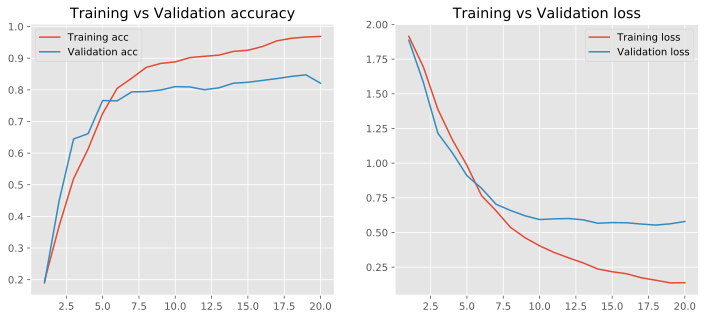

In [363]:
plot_history(hist)

In [ ]:
model_save_path = "modelsV1/"

EPOCHS = 10
BATCH_SIZE = 16

input = Input(shape=(MAX_SENT_LEN,))

model = Embedding(input_dim = VOCAB_SIZE, output_dim = 100, input_length = MAX_SENT_LEN)(input)
model = Dropout(0.1)(model)

model = Bidirectional(LSTM(units=200, recurrent_dropout=0.1))(model)
model = Dense(128, activation="relu")(model)  
out = Dense(NUM_CLASSES, activation="softmax")(model)  

model = Model(input, out)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


In [373]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 600, 100)          8234800   
_________________________________________________________________
dropout_16 (Dropout)         (None, 600, 100)          0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 400)               481600    
_________________________________________________________________
dense_31 (Dense)             (None, 128)               51328     
_________________________________________________________________
dense_32 (Dense)             (None, 7)                 903       
Total params: 8,768,631
Trainable params: 8,768,631
Non-trainable params: 0
_________________________________________________________________


In [364]:

# creating checkpoint to save model every time validation accuracy improves
filepath = model_save_path + "val_acc-improvement-{epoch:02d}-{val_acc:.4f}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

print('\n\nTraining Model...')

history3 = model.fit(x_train, y_train,
              batch_size = BATCH_SIZE,
              epochs = EPOCHS,
              callbacks = callbacks_list,
              validation_data = (x_test, y_test))




Training Model...
Train on 4086 samples, validate on 1022 samples
Epoch 1/10
4086/4086 [==============================] - 1117s 273ms/step - loss: 1.2248 - acc: 0.5318 - val_loss: 0.6791 - val_acc: 0.7534

Epoch 00001: val_acc improved from -inf to 0.75342, saving model to modelsV1/val_acc-improvement-01-0.7534.hdf5
Epoch 2/10
4086/4086 [==============================] - 1103s 270ms/step - loss: 0.3306 - acc: 0.8916 - val_loss: 0.4867 - val_acc: 0.8591

Epoch 00002: val_acc improved from 0.75342 to 0.85910, saving model to modelsV1/val_acc-improvement-02-0.8591.hdf5
Epoch 3/10
4086/4086 [==============================] - 1068s 261ms/step - loss: 0.1498 - acc: 0.9586 - val_loss: 0.5063 - val_acc: 0.8523

Epoch 00003: val_acc did not improve from 0.85910
Epoch 4/10
4086/4086 [==============================] - 1054s 258ms/step - loss: 0.1154 - acc: 0.9672 - val_loss: 0.5742 - val_acc: 0.8307

Epoch 00004: val_acc did not improve from 0.85910
Epoch 5/10
4086/4086 [=======================

KeyboardInterrupt: 

In [371]:
hist2 = pd.DataFrame(model.history.history)
hist2

,val_loss,val_acc,loss,acc
0,0.679103,0.753425,1.224788,0.531816
1,0.486682,0.859100,0.330560,0.891581
2,0.506311,0.852250,0.149825,0.958639
3,0.574230,0.830724,0.115427,0.967205
4,0.550934,0.845401,0.086679,0.972589
5,0.581531,0.818982,0.091201,0.971121
6,0.549139,0.843444,0.075137,0.974547
7,0.665471,0.809198,0.063385,0.975281


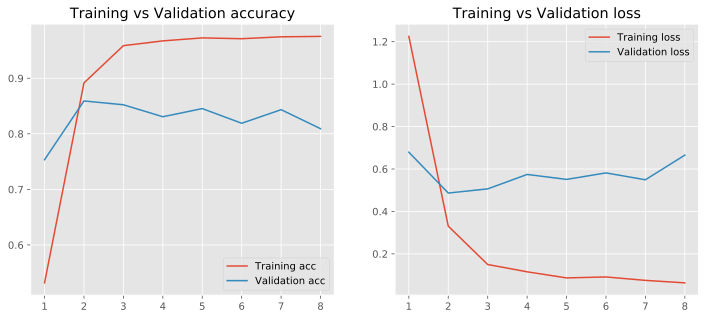

In [372]:
plot_history(hist2)

In [379]:
#current_model = load_model("modelsV1/val_acc-improvement-02-0.8591.hdf5")

#y_pred2 = current_model.predict(x_test)
#y_pred2icted = y_pred2icted.argmax(axis= 1)

print(y_test.shape, y_pred2.shape)
print(y_test.argmax(axis= 1).shape, y_pred2.argmax(axis= 1).shape)

print ('\nClassification Report:')
print (classification_report(y_test.argmax(axis= 1), y_pred2.argmax(axis= 1)))

print ('\nConfusion Matrix:')
confusion_mat = confusion_matrix(y_test.argmax(axis= 1), y_pred2.argmax(axis= 1))
pd.DataFrame(confusion_mat, columns = classes, index = classes)


(1022, 7) (1022, 7)
(1022,) (1022,)

Classification Report:
             precision    recall  f1-score   support

          0       0.77      0.67      0.72       135
          1       0.91      0.92      0.91       158
          2       0.90      0.99      0.94       158
          3       0.91      0.88      0.89       173
          4       0.91      0.91      0.91       187
          5       0.81      0.77      0.79       149
          6       0.64      0.79      0.71        62

avg / total       0.86      0.86      0.86      1022


Confusion Matrix:


,business,science,politics,entertainment,sports,technology,automobile
business,91,1,6,0,1,17,19
science,0,145,2,3,3,3,2
politics,1,0,156,1,0,0,0
entertainment,4,1,5,152,10,1,0
sports,3,2,3,7,171,1,0
technology,15,8,2,1,3,114,6
automobile,4,2,0,3,0,4,49


In [425]:
print(sorted([(class2idx[c], c) for c in classes]))
data.head(20)

[(0, 'business'), (1, 'science'), (2, 'politics'), (3, 'entertainment'), (4, 'sports'), (5, 'technology'), (6, 'automobile')]


,source_article,category,source_article_len
3606,govt considers merging power finance rec repor...,business,310
3484,adani bags operating rights guwahati airport w...,business,139
2265,astronomers identify oldest galaxies universe ...,science,433
5196,felt like chopping hand misa bharti ram kripal...,politics,169
3486,centre reduces fuel prices 2.5 tells states tu...,business,286
3133,karni sena members gathered outside kangana ra...,entertainment,155
1512,sarfaraz ahmed lashes shoaib akhtar reaching p...,sports,178
4135,rosneft slams indian taxation system calls hur...,business,279
668,daimler test self-driving cars public roads be...,technology,185
2566,koffee karan kartik aaryan reveals date sara a...,entertainment,389


In [416]:
def make_prediction(article_idx):
    article_vec = x_padded[article_idx] 
    pred_score = current_model.predict([[article_vec]])
    
    print("**Article: \n", data.iloc[article_idx].source_article)
    print("\n-->Scores:", pred_score, pred_score.argmax(axis=1))
    print("\n-->Predicted Category:", classes[pred_score.argmax(axis=1)[0]])
    print("-->Actual Category:", classes[y[article_idx]])


In [426]:
make_prediction(16)

**Article: 
 germany hits back trump criticism refugee policy bmw tariff threat berlin mounted staunch defence policies donald trump criticised german chancellor angela merkel stance refugee crisis threatened tariff bmw cars imported us. germany deputy chancellor minister economy sigmar gabriel said monday morning tax german imports would lead bad awakening among carmakers since reliant transatlantic supply chains. donald trump's first post-election interview brexit 'great thing' read believe bmw biggest factory already spartanburg south carolina gabriel leader centre-left social democratic party told bild newspaper video interview. car industry would bad awakening supply parts built suddenly come tariff. believe would make car industry weaker worse expensive. would wait see congress say mostly full people want opposite trump. interview bild times president-elect indicated would aim realign balance car trade germany us. fifth avenue everyone mercedes benz front house case said. many ch

In [ ]:
model = Sequential()

model.add(Dense(256, kernel_regularizer=regularizers.l1(0.001), activation='relu', input_shape=(MAX_SENT_LEN,)))
model.add(Dropout(0.2))

model.add(Dense(256, kernel_regularizer=regularizers.l1(0.001), activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(NUM_CLASSES, activation='softmax'))


In [ ]:

score, acc = model_lstm.evaluate(x_test_seq, y_test, batch_size = BATCH_SIZE)

print("\nTesting time: %.4f seconds." % (timeit.default_timer() - start))
print('\nTest score:', score)
print('Test accuracy:', acc)
